In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn

import healpy as hp
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db


In [2]:
plt.rc('legend', fontsize=20) # using a size in points
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rcParams['axes.labelsize'] = 16

In [3]:
# load opsim database
dbpath = "/home/idies/workspace/lsst_cadence/FBS_1.5/"  # path to all opsim databases

# output directory
outDir = '/home/idies/workspace/Temporary/lixl/scratch/outDir'
resultsDb = db.ResultsDb(outDir=outDir)



In [4]:
# get the name of all opsim dbs 
import glob

workpath = os.getcwd()
os.chdir(dbpath)  # change to opsim database directory
dblist_all = glob.glob('*.db') 
#workpath = '/home/idies/workspace/Storage/lixl/persistent/LSST_OpSim/unknowns/timeGaps/'
os.chdir(workpath) # change back to work directory
dblist_all.sort()



In [5]:
dblist_all[5:6]

['baseline_v1.5_10yrs.db']

In [5]:
def RADec2pix(nside, ra, dec, degree=True):
    """
    Calculate the nearest healpixel ID of an RA/Dec array, assuming nside.

    Parameters
    ----------
    nside : int
        The nside value of the healpix grid.
    ra : numpy.ndarray
        The RA values to be converted to healpix ids, in degree by default.
    dec : numpy.ndarray
        The Dec values to be converted to healpix ids, in degree by default.

    Returns
    -------
    numpy.ndarray
        The healpix ids.
    """
    if degree:
        ra = np.radians(ra) # change to radians
        dec = np.radians(dec)
    
    lat = np.pi/2. - dec
    hpid = hp.ang2pix(nside, lat, ra )
    return hpid

def pix2radec(nside, ipix, degree=True):
    """from ipix to ra/dec"""
    
    theta, phi = hp.pix2ang(nside, ipix)
    ra = phi
    dec = np.pi/2. - theta
    if degree:
        ra = np.rad2deg(ra)
        dec = np.rad2deg(dec)
    return ra, dec

In [6]:
from lsst.sims.maf.utils import m52snr

class filterPairTGapsMetric(metrics.BaseMetric):
    """
    returns
    N_v * np.exp(-Dkl) for each fields
    
    Parameters:
        colname: 
        fltpair: filter pair, eg ['r', 'i']
        snr_lim: list, signal to noise ratio (fiveSigmaDepth) threshold for fltpair, default [5, 5]
        filename: output a csv table for time gaps of each field
    
    """

    def __init__(self, colname=['observationStartMJD', 'filter', 'fiveSigmaDepth'], fltpair=['r', 'i'], tmin=0, tmax=1.5/24, bins=50, mag_lim=[18, 18],
                 save_dT=False, filename=None, dataout=True, **kwargs):
        self.colname = colname
        self.filename = filename
        self.fltpair = fltpair
        self.mag_lim = mag_lim
        self.dataout = dataout
        self.tmin = tmin
        self.tmax = tmax
        self.bins = bins
        self.save_dT = save_dT
        
        self.Nrun = 0   # record the how many time run run()
        if filename!=None:
            if os.path.isfile(filename):
                # rm old file
                os.system("rm {}".format(filename))
                
        if self.dataout:
            super().__init__(col=self.colname, metricDtype='object', **kwargs)
        else:
            super().__init__(col=self.colname, metricDtype='float', **kwargs)
    
    def save_to_file(self, dic, filename="test_pkl.pkl"):
        '''save dict item to pickle file'''
        
        #df = self.load_from_pkl(filename)

        #df = df.append(pd.DataFrame(dic), ignore_index=True)

        #df.to_pickle(filename)
        df = pd.DataFrame(dic)
        with open(filename, 'a') as f:
            df.to_csv(f, header=f.tell()==0, index=None)
    
    def get_Dkl_i(self, values):
        '''kl divergence for histogram'''
        if values.any():
            values = values + 0.00001  # make each element non-zero
            prob = (values) / values.sum()  
        
            prob_uni = np.ones( len(prob) ) / len(prob)
            return np.sum( prob_uni * np.log(prob_uni / prob) )
        
        else:
            return np.NaN
        
    def get_FoM_i(self, dT_all, tmin=0, tmax=1.5/24, bins=50):
        """return FoM from array of metricValues"""
                
        dT_tlim = dT_all[(dT_all>tmin)&(dT_all<tmax)] 
        Nv = len(dT_tlim)
    
        values, bins_ = np.histogram(dT_tlim, bins=bins);
    
        Dkl = self.get_Dkl_i(values)
    
        FoM_i = Nv * np.exp(-Dkl)
        
        #print(self.Nrun, len(dT_all), Nv, Dkl, FoM_i)
        return Nv, Dkl, FoM_i, dT_tlim
      
    def run(self, dataSlice, slicePoint=None):
        
        # return all possible time gaps for each fields
        
        f0 = self.fltpair[0]
        f1 = self.fltpair[1]
        
        #check input config
        #print(f0, f1, self.tmin, self.tmax, self.mag_lim)
            
        # sort dataSlice
        
        idx0 = ( dataSlice['filter'] == f0 ) & ( dataSlice['fiveSigmaDepth'] > self.mag_lim[0])
        idx1 = ( dataSlice['filter'] == f1 ) & ( dataSlice['fiveSigmaDepth'] > self.mag_lim[1])
        
        timeCol0 = dataSlice['observationStartMJD'][idx0]
        timeCol1 = dataSlice['observationStartMJD'][idx1]

        timeCol0 = timeCol0.reshape((len(timeCol0), 1))
        timeCol1 = timeCol1.reshape((len(timeCol1), 1))
        
        #print( 'length of dataSlice', dataSlice.shape )
        # calculate time gaps matrix
        diffmat = np.abs( np.subtract(timeCol0, timeCol1.T) ) 
        
        # collect all time gaps
        if f0==f1:
            # get only triangle part
            dt_tri = np.tril(diffmat, -1)
            dT = dt_tri[dt_tri!=0]    # flatten lower triangle 
        else:
            dT = diffmat.flatten()

        Nv, Dkl, FoM_i, dT_tlim = self.get_FoM_i(dT, tmin=self.tmin, tmax=self.tmax, bins=self.bins)
        
        # print(self.Nrun, np.min(dataSlice['fiveSigmaDepth'][idx0]), np.min(dataSlice['fiveSigmaDepth'][idx1]),)
        self.Nrun += 1
        # write results to csv file
        fieldRA = np.mean(dataSlice['fieldRA']) ,
        fieldDec = np.mean(dataSlice['fieldDec']),
        
        if self.save_dT:
            dic = {'Nrun': self.Nrun, 
                'pixId': RADec2pix(nside=16, ra=fieldRA, dec=fieldDec)[0],
                'Nv': Nv,
                'Dkl': Dkl,
                'FoM_i': FoM_i,
                'dT_lim': dT_tlim
                  }
        else:
            dic = {'Nrun': self.Nrun, 
                'pixId': RADec2pix(nside=16, ra=fieldRA, dec=fieldDec)[0],
                'Nv': Nv,
                'Dkl': Dkl,
                'FoM_i': FoM_i,
                # 'dT_lim': dT_tlim
                  }
            
        if self.filename!=None:
            self.save_to_file(dic, filename=self.filename)
        
        if self.dataout:
            # return dT
            result = dic
            return result
        else:
        #    f0 = self.fltpair[0]
        #    f1 = self.fltpair[1]
            result = np.min(dT) if len(dT)!=0 else np.inf
            return float(result) 



In [7]:
def runMetric(dbname, fltpair, ipix_ms=None, nside=16, sqlstr=None,
              colname=['observationStartMJD', 'filter', 'fiveSigmaDepth'],
              tmin=0, tmax=1.5/24, bins=50, mag_lim=[18, 18],
              filename=None, dataout=True, **kwargs
             ):
    """run filterPairTGapsMetric
    dbname: name of opsim database
    fltpair: filter pair, eg: 'ri'
    ipix_ms: pixIds of footprint
    """
    opsdb = db.OpsimDatabase(dbpath+dbname)
    
    #fltpair = ['r', 'i']
    
    if ipix_ms!=None:
        # use UserPointsSlicer for minisurvey
        ra, dec = pix2radec(nside=nside, ipix=ipix_ms)
        slicer = slicers.UserPointsSlicer(ra, dec, latLonDeg=True, badval=0)
    else:
        # use HealpixSlicer 
        slicer = slicers.HealpixSlicer(nside=nside)
    
    # metric, slicer, constraint
    metric = filterPairTGapsMetric( colname=colname, fltpair=fltpair, tmin=tmin, tmax=tmax, bins=bins, mag_lim=mag_lim,
                 filename=filename, dataout=dataout, **kwargs)
    
    sqlconstraint = 'filter in ("{}", "{}")'.format(*fltpair)
    if sqlstr!=None:
        sqlconstraint += ' and {}'.format(sqlstr)
        
    # bundle
    newMetricSky = metricBundles.MetricBundle(metric, slicer, sqlconstraint)
    
    # group bundle
    bundleDict = {'newMetricSky':newMetricSky}
    group = metricBundles.MetricBundleGroup(bundleDict, opsdb, outDir = outDir, resultsDb=resultsDb)
    
    # run
    group.runAll()
    #group.plotAll(closefigs = False)
    return newMetricSky



In [8]:
ipix_LMC = [2899, 2900, 2901, 2934, 2935, 2936, 2965, 2966, 2967, 2992, 2993, 2994]
ipix_SMC = [2960, 2961, 2988, 2989, 3012]
ipix_GP = [ 144,  145,  146,  147,  179,  180,  181,  182,  183,  184,  217,
        218,  219,  225,  226,  260,  261,  271,  272,  307,  308,  320,
        321,  358,  374,  413,  431,  432,  471,  472,  493,  534,  535,
        558,  598,  599,  622,  661,  662,  687,  725,  726,  751,  788,
        789,  790,  815,  816,  852,  853,  854,  879,  915,  916,  917,
        944,  979,  980,  981, 1008, 1042, 1043, 1044, 1045, 1073, 1107,
       1108, 1109, 1136, 1170, 1171, 1172, 1201, 1234, 1235, 1236, 1237,
       1265, 1297, 1298, 1299, 1300, 1330, 1361, 1362, 1363, 1364, 1393,
       1425, 1426, 1427, 1428, 1458, 1489, 1490, 1491, 1492, 1522, 1552,
       1553, 1554, 1555, 1587, 1616, 1617, 1618, 1619, 1620, 1650, 1679,
       1680, 1681, 1682, 1683, 1715, 1744, 1745, 1746, 1747, 1779, 1807,
       1808, 1809, 1810, 1811, 1843, 1871, 1872, 1873, 1874, 1875, 1907,
       1934, 1935, 1936, 1937, 1938, 1972, 1998, 1999, 2000, 2001, 2002,
       2003, 2036, 2062, 2063, 2064, 2065, 2066, 2100, 2126, 2127, 2128,
       2129, 2130, 2164, 2189, 2190, 2191, 2192, 2193, 2194, 2229, 2253,
       2254, 2255, 2256, 2257, 2258, 2293, 2316, 2317, 2318, 2319, 2320,
       2321, 2358, 2380, 2381, 2382, 2383, 2384, 2385, 2421, 2422, 2443,
       2444, 2445, 2446, 2447, 2448, 2449, 2486, 2487, 2507, 2508, 2509,
       2510, 2511, 2512, 2513, 2550, 2551, 2570, 2571, 2572, 2573, 2574,
       2575, 2576, 2614, 2630, 2631, 2632, 2633, 2634, 2635, 2636, 2673,
       2687, 2688, 2689, 2690, 2691, 2692, 2693, 2728, 2729, 2739, 2740,
       2741, 2742, 2743, 2744, 2745, 2746, 2779, 2780, 2781, 2787, 2788,
       2789, 2790, 2791, 2792, 2793, 2794, 2826, 2827, 2828, 2829, 2830,
       2831, 2832, 2833, 2834, 2835, 2836, 2837, 2838, 2839, 2869, 2870,
       2871, 2872, 2873, 2874, 2875, 2876, 2877, 2878, 2879, 2908, 2909,
       2910, 2911, 2912, 2913, 2914, 2915, 2916, 2943, 2944, 2945, 2946,
       2947, 2948, 2974, 2975, 2976]


In [10]:
df = pd.read_csv('./data/Fields_nside16.csv')
# LMC, SMC
df['inLMC'] = np.isin(df['pixId'].values, ipix_LMC)
df['inSMC'] = np.isin(df['pixId'].values, ipix_SMC)
df['inGP'] = np.isin(df['pixId'].values, ipix_GP)

df.head()

,pixId,fieldRa,fieldDec,fieldGl,fieldGb,fieldEl,fieldEb,starDensity_r25,TRIstarDensity_r25,inLMC,inSMC,inGP
0,0,45.0,87.075820,124.642960,24.641921,85.217963,64.413844,0,0,False,False,False
1,1,135.0,87.075820,125.753479,28.655621,94.800547,64.412987,0,0,False,False,False
2,2,225.0,87.075820,121.143387,29.592908,95.668530,68.533082,0,0,False,False,False
3,3,315.0,87.075820,120.187742,25.546039,84.354664,68.534126,0,0,False,False,False
4,4,22.5,84.149733,123.982115,21.356778,77.697559,63.791264,0,0,False,False,False


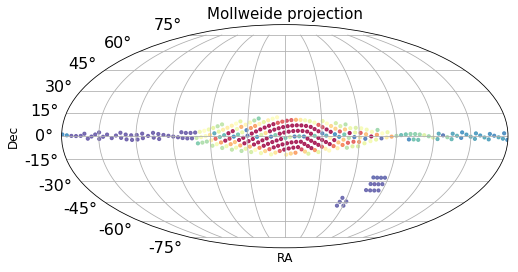

In [15]:
# plot footprint
fig, axs = plt.subplots(1, 1, figsize=(8, 8),
                            subplot_kw={'projection': 'mollweide'}); 


slicer = ( df['inLMC'] | df['inSMC'] | df['inGP'])
df_ = df[slicer]

#x = df_['fieldRa']
#y = df_['fieldDec']
x = df_['fieldGl']
y = df_['fieldGb']
#c = np.repeat(1.5, len(x))
c = df_['starDensity_r25']
plot_mwd(axs, RA=x, Dec=y, colorbar=False, c=c, s=10, alpha=0.8, vmax=1000000, cmap=plt.cm.Spectral_r)

axs.set_xticklabels([]);

### test run for one opsim

In [11]:
dblist_all[18]

'dcr_nham2_ugri_v1.5_10yrs.db'

In [37]:
ipix_ms = ipix_GP
#dbname = dblist_all[4] # baseline
#dbname = dblist_all[0]

dbname = 'third_obs_pt45v1.5_10yrs.db'
# run one filter pair for baseline
metricSky = runMetric( dbname=dbname, fltpair=['g', 'i'], 
              ipix_ms=ipix_ms, nside=16, sqlstr=None,
              colname=['observationStartMJD', 'filter', 'fiveSigmaDepth'],
              tmin=0, tmax=1.5/24, bins=50, mag_lim=[18, 18],
              filename=None, dataout=True, save_dT=True)


Querying database SummaryAllProps with constraint filter in ("g", "i") for columns ['fiveSigmaDepth', 'filter', 'fieldRA', 'observationStartMJD', 'fieldDec']
Found 719288 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [38]:
arr = metricSky.metricValues.data 
        
df = pd.DataFrame.from_records( arr[ arr != None ] )

In [39]:
df

,Dkl,FoM_i,Nrun,Nv,dT_lim,pixId
0,NaN,NaN,1,0,[],622
1,NaN,NaN,2,0,[],661
2,7.833782,0.000792,3,2,"[0.058358355876407586, 0.05794391539529897]",687
3,7.371144,0.000629,4,1,[0.06071237652213313],725
4,NaN,NaN,5,0,[],726
5,8.011193,0.001990,6,6,"[0.05629939065693179, 0.05670790503791068, 0.0...",751
6,8.225301,0.000803,7,3,"[0.014530358188494574, 0.013707963880733587, 0...",788
7,8.275543,0.001273,8,5,"[0.01618225729907863, 0.06111965853051515, 0.0...",789
8,7.371144,0.000629,9,1,[0.06030014438147191],790
9,8.008905,0.000997,10,3,"[0.03950954032188747, 0.04129989320063032, 0.0...",815


In [167]:
dbname

'filterdist_indx1_v1.5_10yrs.db'

In [175]:
data_df = get_cols(dbpath + dbname, cols='fieldRA, fieldDec, night, observationStartMJD, filter, fiveSigmaDepth')


connect to  /home/idies/workspace/lsst_cadence/FBS_1.5/filterdist_indx1_v1.5_10yrs.db 
 SELECT fieldRA, fieldDec, night, observationStartMJD, filter, fiveSigmaDepth FROM SummaryAllProps


In [177]:
data_df['pixId'] = RADec2pix(nside=16, ra=data_df.fieldRA.values, dec=data_df.fieldDec.values )


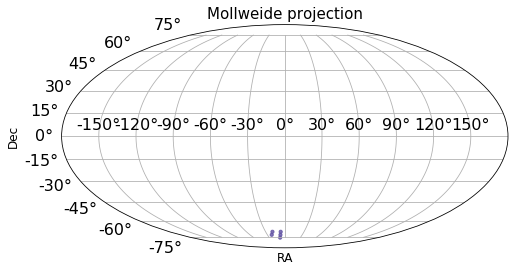

In [214]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8),
                            subplot_kw={'projection': 'mollweide'}); 

ra, dec = pix2radec(nside=16, ipix=ipix_SMC)
x = ra
y = dec
c = np.repeat(1.5, len(x))

plot_mwd(ax=ax, RA=x, Dec=y, colorbar=False, c=c, s=10, alpha=0.8, vmax=1000000, cmap=plt.cm.Spectral_r)




### run time gaps metrics

In [9]:
def get_Dkl(values):
    '''kl divergence for histogram'''
    if values.any():
        values = values + 0.00001  # make each element non-zero
        prob = (values) / values.sum()  
    
        prob_uni = np.ones( len(prob) ) / len(prob)
        return np.sum( prob_uni * np.log(prob_uni / prob) )
    
    else:
        return np.NaN

def get_FoM_tgaps(df, tmin=0, tmax=1.5/24, bins=50):
    """return FoM from array of metricValues
    Inputs:
     df: pd.DataFrame, cols ['pixId', 'Dkl', 'FoM_i', 'Nv', 'dT_lim']
    """
    
    dT_all = np.concatenate(df.dT_lim.values)
    
    dT_tlim = dT_all[(dT_all>tmin)&(dT_all<tmax)] 
    Nv = len(dT_tlim)

    values, bins_ = np.histogram(dT_tlim, bins=bins);

    Dkl = get_Dkl(values)

    FoM = Nv * np.exp(-Dkl)
    
    return FoM


In [10]:
fltpairs = ['uu', 'ug', 'ur', 'ui', 'uz', 'uy', 'gg', 'gr', 'gi', 'gz', 'gy',
           'rr', 'ri', 'rz', 'ry', 'ii', 'iz', 'iy', 'zz', 'zy', 'yy' ]

In [11]:
dblist_all[5:6 ]

['baseline_v1.5_10yrs.db']

In [12]:
%%time 
# run all filter pairs for baseline 

dicFoM = {}
dicFoM['db'] = dblist_all[5:6]

assert(dicFoM['db'] == ['baseline_v1.5_10yrs.db'] )

nside = 16
# select mini survey footprint 
ipix_ms = ipix_GP
msname = 'GP' # minisurvey label used to save files
#sqlstr = "night<4000 and proposalId=1"
#sqlstr = "proposalId=1"
sqlstr = "note not like '%DD%'"

magdic = {'u':18, 'g':18, 'r':18, 'i':18, 'z':18, 'y':18}

dataRaw = {}  # save the raw metricValues.data for each opsim each fltpair; dataRaw[fltpair][dbname]

for fltpair in fltpairs: 
    dicFoM[fltpair] = []
    dataRaw[fltpair] = {}
    for dbname in dicFoM['db']: 
        if fltpair[0]==fltpair[1]:
            tmin = 5/60/60/24 # in days
            tmax = 3e8/60./60./24    
            # histogram in log space
            bins=np.logspace(np.log10(tmin), np.log10(tmax), 50)
            
        else:
            tmin = 5/60/60/24
            #tmax = 1.5/24 # 1.5 hour in days
            tmax = 2
            bins = np.linspace(tmin, tmax, 50)
            
        metricSky = runMetric(dbname, fltpair=fltpair, sqlstr=sqlstr, nside=nside, ipix_ms=ipix_ms, 
                                 mag_lim=[magdic[fltpair[0]], magdic[fltpair[1]]],
                                 tmin=tmin, tmax=tmax, bins=bins,
                                 filename=None, save_dT=True, dataout=True );
            
        arr = metricSky.metricValues.data 
                
        df = pd.DataFrame.from_records( arr[ arr != None ] )
            
        FoM_tgaps = get_FoM_tgaps(df=df, tmin=tmin, tmax=tmax, bins=bins)

        dicFoM[fltpair].append(FoM_tgaps)
        
        dataRaw[fltpair][dbname] = pd.DataFrame.from_records( arr[ arr != None ] )[['pixId', 'Dkl', 'FoM_i', 'Nv']]  
        
        print('>>>', fltpair, dbname, FoM_tgaps)
        
    df_fom = pd.DataFrame(dicFoM)
    df_fom.to_csv('data_v1_5/tgaps_FoM_baseline_v1.5_{}__2d.csv'.format(msname), index=False)
    # save raw data to pickle
    pd.DataFrame( dataRaw ).to_pickle(outDir+'/dataRaw_v1_5//tgaps_dataRaw_baseline_v1.5_{}_wfd_2d.pkl'.format(msname),)



Querying database SummaryAllProps with constraint filter in ("u", "u") and proposalId=1 for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 117746 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> uu baseline_v1.5_10yrs.db 573.4684297527492
Querying database SummaryAllProps with constraint filter in ("u", "g") and proposalId=1 for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 290758 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> ug baseline_v1.5_10yrs.db 0.8218588953143587
Querying database SummaryAllProps with constraint filter in ("u", "r") and proposalId=1 for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 522979 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.


In [13]:
msname = 'GP'
df_dataRaw = pd.read_pickle( outDir+'/dataRaw_v1_5/tgaps_dataRaw_baseline_v1.5_{}_wfd_2d.pkl'.format(msname) )


In [ ]:
df_dataRaw['rr']['baseline_v1.5_10yrs.db']

In [14]:
# get the median of N visits for each filter pair, 

Nvth = {}
for fltpair in fltpairs: 
    df = df_dataRaw[fltpair]['baseline_v1.5_10yrs.db']
    Nvth[fltpair] = np.median( df.Nv ) 
    

In [15]:
Nvth

{'uu': 1711.0,
 'ug': 62.0,
 'ur': 73.0,
 'ui': 22.0,
 'uz': 1.5,
 'uy': 0.0,
 'gg': 3570.0,
 'gr': 123.0,
 'gi': 42.0,
 'gz': 11.0,
 'gy': 4.0,
 'rr': 19900.0,
 'ri': 177.0,
 'rz': 33.5,
 'ry': 16.0,
 'ii': 20301.0,
 'iz': 199.5,
 'iy': 95.5,
 'zz': 16110.0,
 'zy': 203.5,
 'yy': 17564.0}

In [16]:
Fields = pd.read_csv("./data/Fields_nside16.csv")
starDens = Fields['starDensity_r25'].values
TRIstarDens = Fields['TRIstarDensity_r25'].values

In [ ]:
#### %%time 

# run for all opsims all filter pairs

dicFoMtGaps = {}
dicNfields = {}
dicNstar = {}

dbnames = dblist_all
dicFoMtGaps['db'] = dbnames
dicNfields['db'] = dbnames
dicNstar['db'] = dbnames

nside = 16

# select mini survey footprint 
ipix_ms = ipix_GP
msname = 'GP' # minisurvey label used to save files
#sqlstr = "night<4000 and proposalId=1"
#sqlstr = "proposalId=1"

sqlstr = "note not like '%DD%'"
#sqlstr = None

magdic = {'u':18, 'g':18, 'r':18, 'i':18, 'z':18, 'y':18}

#--------------------------------
# empty metricArr 
diclist = []
for Nrun in range( len(ipix_ms) ):
    dic = {'Nrun': Nrun, 
                'pixId': ipix_ms[Nrun],
                'Nv': 0,
                'Dkl': 0,
                'FoM_i': 0,
                'dT_lim': []
                  }
    diclist.append(dic)
arr_empty = np.array(diclist)
df_empty = pd.DataFrame.from_records( arr_empty )
#--------------------------------

dataRaw = {}  # save the raw metricValues.data for each opsim each fltpair; dataRaw[fltpair][dbname]
#for fltpair in fltpairs[8:]:  
for fltpair in fltpairs:  
    dicFoMtGaps[fltpair] = []
    dicNfields[fltpair] = []
    dicNstar[fltpair] = []
    
    dataRaw[fltpair] = {}
    for dbname in dbnames: 

        print('running ', dbname, fltpair)
        if fltpair[0]==fltpair[1]:
            tmin = 5/60/60/24 # in days
            tmax = 3e8/60./60./24    
            # histogram in log space
            bins=np.logspace(np.log10(tmin), np.log10(tmax), 50)
            
        else:
            tmin = 5/60/60/24
            #tmax = 1.5/24 # 1.5 hour in days
            tmax = 2
            bins = np.linspace(tmin, tmax, 50)
            
        metricSky = runMetric(dbname, fltpair=fltpair, sqlstr=sqlstr, nside=nside, ipix_ms=ipix_ms, 
                                 mag_lim=[magdic[fltpair[0]], magdic[fltpair[1]]],
                                 tmin=tmin, tmax=tmax, bins=bins,
                                 filename=None, save_dT=True, dataout=True );
            
        arr = metricSky.metricValues.data 
        
        df = pd.DataFrame.from_records( arr[ arr != None ] )
        if len(df)==0:
            df = df_empty
        # count number of fields/stars above threshold 
        df['starDensity'] = starDens[ df['pixId'].values ] 
        idx = df['Nv'] > Nvth[fltpair]
        Nfields = df['Nv'][idx].shape[0]
        Nstar = np.sum( df['starDensity'][idx] )

        FoM_tgaps = get_FoM_tgaps(df=df, tmin=tmin, tmax=tmax, bins=bins)
                
        dicFoMtGaps[fltpair].append (FoM_tgaps)
        dicNfields[fltpair].append(Nfields)
        dicNstar[fltpair].append(Nstar)
        
        # save the raw data, 
        dataRaw[fltpair][dbname] = df[['pixId', 'Dkl', 'FoM_i', 'Nv']]  
        
        print('>>>', msname, fltpair, dbname, FoM_tgaps, Nfields, Nstar)
    
    df_fom = pd.DataFrame(dicFoMtGaps)
    df_fom.to_csv('data_v1_5/df_tgapsFoM_{}_all_2d.csv'.format(msname), index=False)
    
    df_fom = pd.DataFrame(dicNfields)
    df_fom.to_csv('data_v1_5/df_Nfields_{}_all_2d.csv'.format(msname), index=False)
    
    df_fom = pd.DataFrame(dicNstar)
    df_fom.to_csv('data_v1_5/df_Nstar_{}_all_2d.csv'.format(msname), index=False)
    
    # save raw data to pickle
    pd.DataFrame( dataRaw ).to_pickle(outDir+'/dataRaw_v1_5/tgaps_dataRaw_{}_all_2d.pkl'.format(msname),)




running  agnddf_v1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 137990 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uu agnddf_v1.5_10yrs.db 1344.3176942223402 61 24442956
running  alt_dust_v1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 137491 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uu alt_dust_v1.5_10yrs.db 1259.895408021927 3 1458792
running  alt_roll_mod2_dust_sdf_0.20_v1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") and note not like '%DD%' for columns ['f

Found 135186 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uu descddf_v1.5_10yrs.db 1310.7718547845097 49 20840400
running  filterdist_indx1_v1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 347457 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uu filterdist_indx1_v1.5_10yrs.db 4694.482152173998 195 218169900
running  filterdist_indx2_v1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 144750 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Comple

Found 135732 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uu footprint_standard_goalsv1.5_10yrs.db 1345.6469376213088 53 21480408
running  footprint_stuck_rollingv1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 132608 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uu footprint_stuck_rollingv1.5_10yrs.db 1222.4877420415553 34 14609592
running  goodseeing_gi_v1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 135361 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running su

Found 136177 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uu spiders_v1.5_10yrs.db 1331.105501956804 54 21405636
running  third_obs_pt120v1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 135359 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uu third_obs_pt120v1.5_10yrs.db 1307.5315460309714 52 21040740
running  third_obs_pt15v1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 135826 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> 

Found 144085 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uu wfd_depth_scale0.80_noddf_v1.5_10yrs.db 2469.78749502813 114 99806004
running  wfd_depth_scale0.80_v1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 137448 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uu wfd_depth_scale0.80_v1.5_10yrs.db 2196.0002092380137 54 42035148
running  wfd_depth_scale0.85_noddf_v1.5_10yrs.db uu
Querying database SummaryAllProps with constraint filter in ("u", "u") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 143339 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Run

Found 349855 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ug bulges_cadence_bulge_wfd_v1.5_10yrs.db 4.761179175995952 25 32179500
running  bulges_cadence_i_heavy_v1.5_10yrs.db ug
Querying database SummaryAllProps with constraint filter in ("u", "g") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 348378 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ug bulges_cadence_i_heavy_v1.5_10yrs.db 3.3051894939795194 31 47555244
running  bulges_i_heavy_v1.5_10yrs.db ug
Querying database SummaryAllProps with constraint filter in ("u", "g") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 347605 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running s

Found 346296 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ug footprint_add_mag_cloudsv1.5_10yrs.db 5.082416318684881 107 84677760
running  footprint_big_sky_dustv1.5_10yrs.db ug
Querying database SummaryAllProps with constraint filter in ("u", "g") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 345343 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ug footprint_big_sky_dustv1.5_10yrs.db 0.10580942948523434 7 3327660
running  footprint_big_sky_nouiyv1.5_10yrs.db ug
Querying database SummaryAllProps with constraint filter in ("u", "g") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 349045 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Runn

Found 355777 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ug rolling_mod2_sdf_0.10_v1.5_10yrs.db 2.221105861494018 131 113357304
running  rolling_mod2_sdf_0.20_v1.5_10yrs.db ug
Querying database SummaryAllProps with constraint filter in ("u", "g") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 356724 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ug rolling_mod2_sdf_0.20_v1.5_10yrs.db 4.295287280064763 134 118423620
running  rolling_mod3_sdf_0.10_v1.5_10yrs.db ug
Querying database SummaryAllProps with constraint filter in ("u", "g") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 352888 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Runn

Found 364153 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ug twilight_neo_mod3_v1.5_10yrs.db 1.838233514860435 179 191651724
running  twilight_neo_mod4_v1.5_10yrs.db ug
Querying database SummaryAllProps with constraint filter in ("u", "g") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 360282 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ug twilight_neo_mod4_v1.5_10yrs.db 3.4522271665348776 165 170299512
running  u60_v1.5_10yrs.db ug
Querying database SummaryAllProps with constraint filter in ("u", "g") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 278692 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Compl

Found 332884 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ug wfd_depth_scale0.99_v1.5_10yrs.db 1.2262011443735477 61 25093980
running  agnddf_v1.5_10yrs.db ur
Querying database SummaryAllProps with constraint filter in ("u", "r") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 603123 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ur agnddf_v1.5_10yrs.db 3.7755728129486688 58 24139692
running  alt_dust_v1.5_10yrs.db ur
Querying database SummaryAllProps with constraint filter in ("u", "r") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 600897 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ur al

Found 609838 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ur dcr_nham2_ugri_v1.5_10yrs.db 50.95053966866824 51 20704536
running  descddf_v1.5_10yrs.db ur
Querying database SummaryAllProps with constraint filter in ("u", "r") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 596422 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ur descddf_v1.5_10yrs.db 2.536933953958128 56 22851900
running  filterdist_indx1_v1.5_10yrs.db ur
Querying database SummaryAllProps with constraint filter in ("u", "r") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 715412 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ur

Found 603450 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ur footprint_no_gp_northv1.5_10yrs.db 2.8862462976725736 42 15744348
running  footprint_standard_goalsv1.5_10yrs.db ur
Querying database SummaryAllProps with constraint filter in ("u", "r") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 603509 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ur footprint_standard_goalsv1.5_10yrs.db 3.0503141494954367 58 25180632
running  footprint_stuck_rollingv1.5_10yrs.db ur
Querying database SummaryAllProps with constraint filter in ("u", "r") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 600432 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Ru

Found 773826 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ur short_exp_5ns_5expt_v1.5_10yrs.db 1.5111029649948515 170 162588852
running  spiders_v1.5_10yrs.db ur
Querying database SummaryAllProps with constraint filter in ("u", "r") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 604483 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ur spiders_v1.5_10yrs.db 2.2334787728567007 59 23457744
running  third_obs_pt120v1.5_10yrs.db ur
Querying database SummaryAllProps with constraint filter in ("u", "r") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 606367 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>

Found 614060 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ur wfd_depth_scale0.75_v1.5_10yrs.db 3.0135286380995785 52 22990644
running  wfd_depth_scale0.80_noddf_v1.5_10yrs.db ur
Querying database SummaryAllProps with constraint filter in ("u", "r") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 640797 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ur wfd_depth_scale0.80_noddf_v1.5_10yrs.db 2.3332128831051153 61 30432852
running  wfd_depth_scale0.80_v1.5_10yrs.db ur
Querying database SummaryAllProps with constraint filter in ("u", "r") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 610516 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Ru

Found 607461 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ui bulges_cadence_bs_v1.5_10yrs.db 0.635038259876455 6 3505212
running  bulges_cadence_bulge_wfd_v1.5_10yrs.db ui
Querying database SummaryAllProps with constraint filter in ("u", "i") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 607933 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ui bulges_cadence_bulge_wfd_v1.5_10yrs.db 0.7300385166179216 20 41889708
running  bulges_cadence_i_heavy_v1.5_10yrs.db ui
Querying database SummaryAllProps with constraint filter in ("u", "i") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 615722 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Runnin

Found 616962 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ui filterdist_indx8_v1.5_10yrs.db 0.3190241707744704 142 155716524
running  footprint_add_mag_cloudsv1.5_10yrs.db ui
Querying database SummaryAllProps with constraint filter in ("u", "i") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 606787 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ui footprint_add_mag_cloudsv1.5_10yrs.db 1.182703479215057 61 25510104
running  footprint_big_sky_dustv1.5_10yrs.db ui
Querying database SummaryAllProps with constraint filter in ("u", "i") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 604546 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Runnin

Found 607079 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ui roll_mod2_dust_sdf_0.20_v1.5_10yrs.db 0.5046301655683936 8 4948272
running  rolling_mod2_sdf_0.10_v1.5_10yrs.db ui
Querying database SummaryAllProps with constraint filter in ("u", "i") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 609269 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ui rolling_mod2_sdf_0.10_v1.5_10yrs.db 0.6685256477164778 58 24221592
running  rolling_mod2_sdf_0.20_v1.5_10yrs.db ui
Querying database SummaryAllProps with constraint filter in ("u", "i") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 609318 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Runnin

Found 736869 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ui twilight_neo_mod2_v1.5_10yrs.db 2.0738779802981657 89 54945936
running  twilight_neo_mod3_v1.5_10yrs.db ui
Querying database SummaryAllProps with constraint filter in ("u", "i") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 695547 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ui twilight_neo_mod3_v1.5_10yrs.db 2.81503047337818 72 60962184
running  twilight_neo_mod4_v1.5_10yrs.db ui
Querying database SummaryAllProps with constraint filter in ("u", "i") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 672734 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statisti

Querying database SummaryAllProps with constraint filter in ("u", "i") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 630397 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ui wfd_depth_scale0.99_noddf_v1.5_10yrs.db 0.3715666816593376 74 31597308
running  wfd_depth_scale0.99_v1.5_10yrs.db ui
Querying database SummaryAllProps with constraint filter in ("u", "i") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 601006 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ui wfd_depth_scale0.99_v1.5_10yrs.db 0.479298162003944 67 28075284
running  agnddf_v1.5_10yrs.db uz
Querying database SummaryAllProps with constraint filter in ("u", "z") and note not like '%DD%' for columns ['fiveSigmaDep

Found 562649 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uz dcr_nham2_ugr_v1.5_10yrs.db 0.5970029525684917 136 115881192
running  dcr_nham2_ugri_v1.5_10yrs.db uz
Querying database SummaryAllProps with constraint filter in ("u", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 560298 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uz dcr_nham2_ugri_v1.5_10yrs.db 0.08594367406359792 117 135173340
running  descddf_v1.5_10yrs.db uz
Querying database SummaryAllProps with constraint filter in ("u", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 548967 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed

Found 552075 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uz footprint_newBv1.5_10yrs.db 0.02599484367831885 83 60520248
running  footprint_no_gp_northv1.5_10yrs.db uz
Querying database SummaryAllProps with constraint filter in ("u", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 557115 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uz footprint_no_gp_northv1.5_10yrs.db 0.05963035373581667 88 83101716
running  footprint_standard_goalsv1.5_10yrs.db uz
Querying database SummaryAllProps with constraint filter in ("u", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 556971 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summ

Found 736336 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uz short_exp_5ns_1expt_v1.5_10yrs.db 0.038076593957207486 119 97515900
running  short_exp_5ns_5expt_v1.5_10yrs.db uz
Querying database SummaryAllProps with constraint filter in ("u", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 715111 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uz short_exp_5ns_5expt_v1.5_10yrs.db 0.027952368214088023 106 102436524
running  spiders_v1.5_10yrs.db uz
Querying database SummaryAllProps with constraint filter in ("u", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 559046 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary sta

Found 593585 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uz wfd_depth_scale0.75_noddf_v1.5_10yrs.db 0.01689298055880692 128 138160944
running  wfd_depth_scale0.75_v1.5_10yrs.db uz
Querying database SummaryAllProps with constraint filter in ("u", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 567889 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uz wfd_depth_scale0.75_v1.5_10yrs.db 0.03767201372534426 130 110938428
running  wfd_depth_scale0.80_noddf_v1.5_10yrs.db uz
Querying database SummaryAllProps with constraint filter in ("u", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 591514 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce metho

Found 551520 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uy bulges_bulge_wfd_v1.5_10yrs.db 0.03132497834084722 78 89161596
running  bulges_cadence_bs_v1.5_10yrs.db uy
Querying database SummaryAllProps with constraint filter in ("u", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 551293 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uy bulges_cadence_bs_v1.5_10yrs.db 0.015842803323219707 39 29110428
running  bulges_cadence_bulge_wfd_v1.5_10yrs.db uy
Querying database SummaryAllProps with constraint filter in ("u", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 551420 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summa

Found 637551 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uy filterdist_indx7_v1.5_10yrs.db 0.005991288305428161 74 92129364
running  filterdist_indx8_v1.5_10yrs.db uy
Querying database SummaryAllProps with constraint filter in ("u", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 633147 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uy filterdist_indx8_v1.5_10yrs.db 0.01518161311786827 96 126828864
running  footprint_add_mag_cloudsv1.5_10yrs.db uy
Querying database SummaryAllProps with constraint filter in ("u", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 550694 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary

Found 551875 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uy greedy_footprint_v1.5_10yrs.db 0.00752478380317545 71 52272828
running  roll_mod2_dust_sdf_0.20_v1.5_10yrs.db uy
Querying database SummaryAllProps with constraint filter in ("u", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 558998 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uy roll_mod2_dust_sdf_0.20_v1.5_10yrs.db 0.010357474716261458 58 90354276
running  rolling_mod2_sdf_0.10_v1.5_10yrs.db uy
Querying database SummaryAllProps with constraint filter in ("u", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 554055 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Runn

Found 669510 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uy twilight_neo_mod1_v1.5_10yrs.db 0.014318125162271938 68 45566172
running  twilight_neo_mod2_v1.5_10yrs.db uy
Querying database SummaryAllProps with constraint filter in ("u", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 618026 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uy twilight_neo_mod2_v1.5_10yrs.db 0.009765463152722862 47 32901912
running  twilight_neo_mod3_v1.5_10yrs.db uy
Querying database SummaryAllProps with constraint filter in ("u", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 597820 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary st

Found 558266 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uy wfd_depth_scale0.95_v1.5_10yrs.db 0.002788162573378764 76 68482224
running  wfd_depth_scale0.99_noddf_v1.5_10yrs.db uy
Querying database SummaryAllProps with constraint filter in ("u", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 591961 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP uy wfd_depth_scale0.99_noddf_v1.5_10yrs.db 0.005991502821024251 69 35137260
running  wfd_depth_scale0.99_v1.5_10yrs.db uy
Querying database SummaryAllProps with constraint filter in ("u", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 565566 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods

Found 213050 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gg dcr_nham2_ug_v1.5_10yrs.db 4090.145986906386 56 22805784
running  dcr_nham2_ugr_v1.5_10yrs.db gg
Querying database SummaryAllProps with constraint filter in ("g", "g") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 213361 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gg dcr_nham2_ugr_v1.5_10yrs.db 4498.550621417983 55 22004784
running  dcr_nham2_ugri_v1.5_10yrs.db gg
Querying database SummaryAllProps with constraint filter in ("g", "g") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 213997 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>

Found 209563 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gg footprint_newAv1.5_10yrs.db 2932.5511741144637 0 0
running  footprint_newBv1.5_10yrs.db gg
Querying database SummaryAllProps with constraint filter in ("g", "g") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 211752 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gg footprint_newBv1.5_10yrs.db 3178.0736525440384 0 0
running  footprint_no_gp_northv1.5_10yrs.db gg
Querying database SummaryAllProps with constraint filter in ("g", "g") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 211336 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP g

Found 238473 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gg short_exp_2ns_5expt_v1.5_10yrs.db 8671.40898609453 72 29011680
running  short_exp_5ns_1expt_v1.5_10yrs.db gg
Querying database SummaryAllProps with constraint filter in ("g", "g") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 278868 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gg short_exp_5ns_1expt_v1.5_10yrs.db 11308.546752721162 85 38118600
running  short_exp_5ns_5expt_v1.5_10yrs.db gg
Querying database SummaryAllProps with constraint filter in ("g", "g") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 270755 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary 

Found 225372 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gg wfd_depth_scale0.70_v1.5_10yrs.db 5152.67940795653 57 40064436
running  wfd_depth_scale0.75_noddf_v1.5_10yrs.db gg
Querying database SummaryAllProps with constraint filter in ("g", "g") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 233271 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gg wfd_depth_scale0.75_noddf_v1.5_10yrs.db 5247.877708128479 44 18455652
running  wfd_depth_scale0.75_v1.5_10yrs.db gg
Querying database SummaryAllProps with constraint filter in ("g", "g") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 221520 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Runni

Found 681274 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gr bulges_bs_v1.5_10yrs.db 4.491758181007317 7 3399120
running  bulges_bulge_wfd_v1.5_10yrs.db gr
Querying database SummaryAllProps with constraint filter in ("g", "r") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 680466 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gr bulges_bulge_wfd_v1.5_10yrs.db 4.413232000208561 17 23902272
running  bulges_cadence_bs_v1.5_10yrs.db gr
Querying database SummaryAllProps with constraint filter in ("g", "r") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 680903 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Complete

Found 630153 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gr filterdist_indx6_v1.5_10yrs.db 2.4738799370925157 92 95830380
running  filterdist_indx7_v1.5_10yrs.db gr
Querying database SummaryAllProps with constraint filter in ("g", "r") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 721523 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gr filterdist_indx7_v1.5_10yrs.db 1.0768747272592762 181 211987476
running  filterdist_indx8_v1.5_10yrs.db gr
Querying database SummaryAllProps with constraint filter in ("g", "r") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 628515 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statisti

Found 678430 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gr goodseeing_i_v1.5_10yrs.db 3.66142328822775 53 21268224
running  greedy_footprint_v1.5_10yrs.db gr
Querying database SummaryAllProps with constraint filter in ("g", "r") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 679210 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gr greedy_footprint_v1.5_10yrs.db 4.567127570707151 57 24294204
running  roll_mod2_dust_sdf_0.20_v1.5_10yrs.db gr
Querying database SummaryAllProps with constraint filter in ("g", "r") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 680939 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics

Found 682870 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gr third_obs_pt90v1.5_10yrs.db 3.8190242440316626 64 25725960
running  twilight_neo_mod1_v1.5_10yrs.db gr
Querying database SummaryAllProps with constraint filter in ("g", "r") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 960007 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gr twilight_neo_mod1_v1.5_10yrs.db 40.42053227867231 66 25787268
running  twilight_neo_mod2_v1.5_10yrs.db gr
Querying database SummaryAllProps with constraint filter in ("g", "r") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 825737 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.

Querying database SummaryAllProps with constraint filter in ("g", "r") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 707901 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gr wfd_depth_scale0.95_noddf_v1.5_10yrs.db 2.8841591880545154 66 27046188
running  wfd_depth_scale0.95_v1.5_10yrs.db gr
Querying database SummaryAllProps with constraint filter in ("g", "r") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 674609 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gr wfd_depth_scale0.95_v1.5_10yrs.db 1.9789093026979963 64 26145792
running  wfd_depth_scale0.99_noddf_v1.5_10yrs.db gr
Querying database SummaryAllProps with constraint filter in ("g", "r") and note not like '%DD%' for co

Querying database SummaryAllProps with constraint filter in ("g", "i") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 683581 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gi dcr_nham1_ugri_v1.5_10yrs.db 17.63345650129885 60 24328584
running  dcr_nham2_ug_v1.5_10yrs.db gi
Querying database SummaryAllProps with constraint filter in ("g", "i") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 682580 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gi dcr_nham2_ug_v1.5_10yrs.db 20.166781070076098 53 22285044
running  dcr_nham2_ugr_v1.5_10yrs.db gi
Querying database SummaryAllProps with constraint filter in ("g", "i") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'f

Found 681786 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gi footprint_gp_smoothv1.5_10yrs.db 1.469481979580346 145 166658796
running  footprint_newAv1.5_10yrs.db gi
Querying database SummaryAllProps with constraint filter in ("g", "i") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 678891 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gi footprint_newAv1.5_10yrs.db 1.9604096851374249 10 7282332
running  footprint_newBv1.5_10yrs.db gi
Querying database SummaryAllProps with constraint filter in ("g", "i") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 680160 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Compl

Found 780590 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gi short_exp_2ns_1expt_v1.5_10yrs.db 1.599081754817898 73 36608436
running  short_exp_2ns_5expt_v1.5_10yrs.db gi
Querying database SummaryAllProps with constraint filter in ("g", "i") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 768621 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gi short_exp_2ns_5expt_v1.5_10yrs.db 1.608122070238245 76 41560740
running  short_exp_5ns_1expt_v1.5_10yrs.db gi
Querying database SummaryAllProps with constraint filter in ("g", "i") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 894922 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary 

Found 742411 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gi wfd_depth_scale0.70_noddf_v1.5_10yrs.db 0.8778568204142878 60 20258316
running  wfd_depth_scale0.70_v1.5_10yrs.db gi
Querying database SummaryAllProps with constraint filter in ("g", "i") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 706085 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gi wfd_depth_scale0.70_v1.5_10yrs.db 0.6258362597027308 48 15510348
running  wfd_depth_scale0.75_noddf_v1.5_10yrs.db gi
Querying database SummaryAllProps with constraint filter in ("g", "i") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 735760 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Ru

Found 633446 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gz baseline_v1.5_10yrs.db 1.9488911208078588 82 49197204
running  bulges_bs_v1.5_10yrs.db gz
Querying database SummaryAllProps with constraint filter in ("g", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 637410 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gz bulges_bs_v1.5_10yrs.db 1.0296692305630668 22 10100520
running  bulges_bulge_wfd_v1.5_10yrs.db gz
Querying database SummaryAllProps with constraint filter in ("g", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 636829 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gz

Found 740175 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gz filterdist_indx5_v1.5_10yrs.db 0.24734398803269778 74 80044380
running  filterdist_indx6_v1.5_10yrs.db gz
Querying database SummaryAllProps with constraint filter in ("g", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 589449 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gz filterdist_indx6_v1.5_10yrs.db 0.7494148452750835 82 99919584
running  filterdist_indx7_v1.5_10yrs.db gz
Querying database SummaryAllProps with constraint filter in ("g", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 678972 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistic

Found 634145 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gz goodseeing_gz_v1.5_10yrs.db 0.9695755211573318 87 42941268
running  goodseeing_i_v1.5_10yrs.db gz
Querying database SummaryAllProps with constraint filter in ("g", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 632132 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gz goodseeing_i_v1.5_10yrs.db 1.824163819227756 67 37314792
running  greedy_footprint_v1.5_10yrs.db gz
Querying database SummaryAllProps with constraint filter in ("g", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 625669 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.

Found 634445 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gz third_obs_pt60v1.5_10yrs.db 1.0652866580652138 72 65853360
running  third_obs_pt90v1.5_10yrs.db gz
Querying database SummaryAllProps with constraint filter in ("g", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 636515 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gz third_obs_pt90v1.5_10yrs.db 1.4521541928697204 62 37148796
running  twilight_neo_mod1_v1.5_10yrs.db gz
Querying database SummaryAllProps with constraint filter in ("g", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 900493 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Comple

Found 632641 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gz wfd_depth_scale0.90_v1.5_10yrs.db 0.965890553250455 94 89031960
running  wfd_depth_scale0.95_noddf_v1.5_10yrs.db gz
Querying database SummaryAllProps with constraint filter in ("g", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 657262 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gz wfd_depth_scale0.95_noddf_v1.5_10yrs.db 0.7695366413158803 73 39809808
running  wfd_depth_scale0.95_v1.5_10yrs.db gz
Querying database SummaryAllProps with constraint filter in ("g", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 627636 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Run

Found 624580 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gy dcr_nham1_ugr_v1.5_10yrs.db 1.619818929438965 101 127841256
running  dcr_nham1_ugri_v1.5_10yrs.db gy
Querying database SummaryAllProps with constraint filter in ("g", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 625300 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gy dcr_nham1_ugri_v1.5_10yrs.db 2.0954806667390073 110 140821164
running  dcr_nham2_ug_v1.5_10yrs.db gy
Querying database SummaryAllProps with constraint filter in ("g", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 625508 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Comple

Found 714314 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gy footprint_bluer_footprintv1.5_10yrs.db 0.8323934144080005 84 111957696
running  footprint_gp_smoothv1.5_10yrs.db gy
Querying database SummaryAllProps with constraint filter in ("g", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 625247 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gy footprint_gp_smoothv1.5_10yrs.db 0.7044157332419055 117 142654500
running  footprint_newAv1.5_10yrs.db gy
Querying database SummaryAllProps with constraint filter in ("g", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 638491 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summar

Found 646210 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gy rolling_mod6_sdf_0.20_v1.5_10yrs.db 1.6294429231675616 96 86464944
running  short_exp_2ns_1expt_v1.5_10yrs.db gy
Querying database SummaryAllProps with constraint filter in ("g", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 711489 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gy short_exp_2ns_1expt_v1.5_10yrs.db 0.994443624882511 113 152782776
running  short_exp_2ns_5expt_v1.5_10yrs.db gy
Querying database SummaryAllProps with constraint filter in ("g", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 700568 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running sum

Found 589694 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gy wfd_depth_scale0.65_v1.5_10yrs.db 0.1322383503574583 42 34178940
running  wfd_depth_scale0.70_noddf_v1.5_10yrs.db gy
Querying database SummaryAllProps with constraint filter in ("g", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 624491 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP gy wfd_depth_scale0.70_noddf_v1.5_10yrs.db 0.20444040893051807 55 38939652
running  wfd_depth_scale0.70_v1.5_10yrs.db gy
Querying database SummaryAllProps with constraint filter in ("g", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 596232 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
R

Found 481496 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP rr baseline_samefilt_v1.5_10yrs.db 4915.591462952904 58 22807512
running  baseline_v1.5_10yrs.db rr
Querying database SummaryAllProps with constraint filter in ("r", "r") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 467643 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP rr baseline_v1.5_10yrs.db 7713.058137668789 57 22860036
running  bulges_bs_v1.5_10yrs.db rr
Querying database SummaryAllProps with constraint filter in ("r", "r") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 465735 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP rr b

Found 435207 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP rr filterdist_indx4_v1.5_10yrs.db 7891.46072420459 127 149923656
running  filterdist_indx5_v1.5_10yrs.db rr
Querying database SummaryAllProps with constraint filter in ("r", "r") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 386481 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP rr filterdist_indx5_v1.5_10yrs.db 13278.829732894836 0 0
running  filterdist_indx6_v1.5_10yrs.db rr
Querying database SummaryAllProps with constraint filter in ("r", "r") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 441092 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Comple

Found 467373 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP rr goodseeing_griz_v1.5_10yrs.db 5799.52474117902 53 22686984
running  goodseeing_gz_v1.5_10yrs.db rr
Querying database SummaryAllProps with constraint filter in ("r", "r") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 467322 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP rr goodseeing_gz_v1.5_10yrs.db 7651.116330700068 53 22233888
running  goodseeing_i_v1.5_10yrs.db rr
Querying database SummaryAllProps with constraint filter in ("r", "r") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 467512 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>

Found 468029 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP rr third_obs_pt45v1.5_10yrs.db 6088.9678222695675 54 20800764
running  third_obs_pt60v1.5_10yrs.db rr
Querying database SummaryAllProps with constraint filter in ("r", "r") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 468976 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP rr third_obs_pt60v1.5_10yrs.db 8248.232117514199 57 22975956
running  third_obs_pt90v1.5_10yrs.db rr
Querying database SummaryAllProps with constraint filter in ("r", "r") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 470200 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


Found 491369 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP rr wfd_depth_scale0.90_noddf_v1.5_10yrs.db 7890.83934986118 66 25504596
running  wfd_depth_scale0.90_v1.5_10yrs.db rr
Querying database SummaryAllProps with constraint filter in ("r", "r") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 467393 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP rr wfd_depth_scale0.90_v1.5_10yrs.db 7395.6686892766165 55 22106052
running  wfd_depth_scale0.95_noddf_v1.5_10yrs.db rr
Querying database SummaryAllProps with constraint filter in ("r", "r") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 489513 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Runn

Found 936949 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ri dcr_nham1_ug_v1.5_10yrs.db 1.591073225032858 69 28318140
running  dcr_nham1_ugr_v1.5_10yrs.db ri
Querying database SummaryAllProps with constraint filter in ("r", "i") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 936623 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ri dcr_nham1_ugr_v1.5_10yrs.db 24.634253583957147 55 22124340
running  dcr_nham1_ugri_v1.5_10yrs.db ri
Querying database SummaryAllProps with constraint filter in ("r", "i") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 937336 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


Found 923892 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ri footprint_big_wfdv1.5_10yrs.db 2.9928009750580267 28 13324140
running  footprint_bluer_footprintv1.5_10yrs.db ri
Querying database SummaryAllProps with constraint filter in ("r", "i") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 927816 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ri footprint_bluer_footprintv1.5_10yrs.db 2.4342671219199024 18 8663544
running  footprint_gp_smoothv1.5_10yrs.db ri
Querying database SummaryAllProps with constraint filter in ("r", "i") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 941081 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running s

Found 935286 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ri rolling_mod6_sdf_0.10_v1.5_10yrs.db 10.088568350751292 72 29526336
running  rolling_mod6_sdf_0.20_v1.5_10yrs.db ri
Querying database SummaryAllProps with constraint filter in ("r", "i") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 932669 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ri rolling_mod6_sdf_0.20_v1.5_10yrs.db 8.440520221798838 76 31951620
running  short_exp_2ns_1expt_v1.5_10yrs.db ri
Querying database SummaryAllProps with constraint filter in ("r", "i") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 1070973 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running 

Found 1010423 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ri wfd_depth_scale0.65_noddf_v1.5_10yrs.db 1.3436170123911733 46 14464332
running  wfd_depth_scale0.65_v1.5_10yrs.db ri
Querying database SummaryAllProps with constraint filter in ("r", "i") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 961276 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ri wfd_depth_scale0.65_v1.5_10yrs.db 1.325197862484341 31 10140120
running  wfd_depth_scale0.70_noddf_v1.5_10yrs.db ri
Querying database SummaryAllProps with constraint filter in ("r", "i") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 1006776 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
R

Found 821222 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP rz baseline_2snaps_v1.5_10yrs.db 3.5864449137328265 49 19596204
running  baseline_samefilt_v1.5_10yrs.db rz
Querying database SummaryAllProps with constraint filter in ("r", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 922139 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP rz baseline_samefilt_v1.5_10yrs.db 1.6126999493979803 80 92592756
running  baseline_v1.5_10yrs.db rz
Querying database SummaryAllProps with constraint filter in ("r", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 889335 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Compl

Found 832876 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP rz filterdist_indx3_v1.5_10yrs.db 0.5898829002965892 123 165429972
running  filterdist_indx4_v1.5_10yrs.db rz
Querying database SummaryAllProps with constraint filter in ("r", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 832317 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP rz filterdist_indx4_v1.5_10yrs.db 1.754775326945289 160 196608960
running  filterdist_indx5_v1.5_10yrs.db rz
Querying database SummaryAllProps with constraint filter in ("r", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 958990 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statist

Found 887916 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP rz goodseeing_gri_v1.5_10yrs.db 2.366587445355611 71 29200896
running  goodseeing_griz_v1.5_10yrs.db rz
Querying database SummaryAllProps with constraint filter in ("r", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 888939 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP rz goodseeing_griz_v1.5_10yrs.db 4.178168549631063 71 28663452
running  goodseeing_gz_v1.5_10yrs.db rz
Querying database SummaryAllProps with constraint filter in ("r", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 889423 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Complet

Found 889805 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP rz third_obs_pt30v1.5_10yrs.db 2.019613797369786 64 25007040
running  third_obs_pt45v1.5_10yrs.db rz
Querying database SummaryAllProps with constraint filter in ("r", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 889952 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP rz third_obs_pt45v1.5_10yrs.db 2.616578722842119 65 33686100
running  third_obs_pt60v1.5_10yrs.db rz
Querying database SummaryAllProps with constraint filter in ("r", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 891058 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>

Found 894981 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP rz wfd_depth_scale0.85_v1.5_10yrs.db 4.233002779879549 68 30102984
running  wfd_depth_scale0.90_noddf_v1.5_10yrs.db rz
Querying database SummaryAllProps with constraint filter in ("r", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 932800 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP rz wfd_depth_scale0.90_noddf_v1.5_10yrs.db 2.4307237048963146 57 23611608
running  wfd_depth_scale0.90_v1.5_10yrs.db rz
Querying database SummaryAllProps with constraint filter in ("r", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 888846 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Run

Found 839855 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ry daily_ddf_v1.5_10yrs.db 3.6683570705238435 79 87742368
running  dcr_nham1_ug_v1.5_10yrs.db ry
Querying database SummaryAllProps with constraint filter in ("r", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 878937 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ry dcr_nham1_ug_v1.5_10yrs.db 2.8519794492251216 79 75590496
running  dcr_nham1_ugr_v1.5_10yrs.db ry
Querying database SummaryAllProps with constraint filter in ("r", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 880306 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> G

Found 881558 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ry footprint_big_skyv1.5_10yrs.db nan 0 0
running  footprint_big_wfdv1.5_10yrs.db ry
Querying database SummaryAllProps with constraint filter in ("r", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 897105 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ry footprint_big_wfdv1.5_10yrs.db 1.4604935088414708 62 51000048
running  footprint_bluer_footprintv1.5_10yrs.db ry
Querying database SummaryAllProps with constraint filter in ("r", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 794493 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>

Found 883321 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ry rolling_mod3_sdf_0.20_v1.5_10yrs.db 4.401187962566844 89 80162136
running  rolling_mod6_sdf_0.10_v1.5_10yrs.db ry
Querying database SummaryAllProps with constraint filter in ("r", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 893710 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ry rolling_mod6_sdf_0.10_v1.5_10yrs.db 5.88213274875046 85 40110516
running  rolling_mod6_sdf_0.20_v1.5_10yrs.db ry
Querying database SummaryAllProps with constraint filter in ("r", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 892951 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running s

Found 829939 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ry var_expt_v1.5_10yrs.db 1.1732363165480877 62 35072172
running  wfd_depth_scale0.65_noddf_v1.5_10yrs.db ry
Querying database SummaryAllProps with constraint filter in ("r", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 880979 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ry wfd_depth_scale0.65_noddf_v1.5_10yrs.db 1.2490122826444874 54 33202224
running  wfd_depth_scale0.65_v1.5_10yrs.db ry
Querying database SummaryAllProps with constraint filter in ("r", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 840469 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summa

Querying database SummaryAllProps with constraint filter in ("i", "i") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 469193 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ii alt_roll_mod2_dust_sdf_0.20_v1.5_10yrs.db 4080.886719078626 3 1630656
running  baseline_2snaps_v1.5_10yrs.db ii
Querying database SummaryAllProps with constraint filter in ("i", "i") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 435138 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ii baseline_2snaps_v1.5_10yrs.db 7892.426191844411 17 8272908
running  baseline_samefilt_v1.5_10yrs.db ii
Querying database SummaryAllProps with constraint filter in ("i", "i") and note not like '%DD%' for columns ['fiveSigmaDe

Found 489288 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ii filterdist_indx2_v1.5_10yrs.db 10975.971907959105 181 211987476
running  filterdist_indx3_v1.5_10yrs.db ii
Querying database SummaryAllProps with constraint filter in ("i", "i") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 429526 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ii filterdist_indx3_v1.5_10yrs.db 7564.97970694992 98 122396436
running  filterdist_indx4_v1.5_10yrs.db ii
Querying database SummaryAllProps with constraint filter in ("i", "i") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 433256 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistic

Found 473043 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ii goodseeing_gi_v1.5_10yrs.db 7452.881963750505 55 22668984
running  goodseeing_gri_v1.5_10yrs.db ii
Querying database SummaryAllProps with constraint filter in ("i", "i") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 472214 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ii goodseeing_gri_v1.5_10yrs.db 5552.88591584875 53 20893788
running  goodseeing_griz_v1.5_10yrs.db ii
Querying database SummaryAllProps with constraint filter in ("i", "i") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 470045 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed

Found 471731 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ii third_obs_pt15v1.5_10yrs.db 7001.64217069084 57 23760864
running  third_obs_pt30v1.5_10yrs.db ii
Querying database SummaryAllProps with constraint filter in ("i", "i") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 471578 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ii third_obs_pt30v1.5_10yrs.db 6896.400044931932 54 21795408
running  third_obs_pt45v1.5_10yrs.db ii
Querying database SummaryAllProps with constraint filter in ("i", "i") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 471458 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>

Found 497885 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ii wfd_depth_scale0.85_noddf_v1.5_10yrs.db 6908.751483278094 56 23924592
running  wfd_depth_scale0.85_v1.5_10yrs.db ii
Querying database SummaryAllProps with constraint filter in ("i", "i") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 474168 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP ii wfd_depth_scale0.85_v1.5_10yrs.db 6922.908475310814 32 14248656
running  wfd_depth_scale0.90_noddf_v1.5_10yrs.db ii
Querying database SummaryAllProps with constraint filter in ("i", "i") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 493995 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Runn

Found 902522 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP iz bulges_i_heavy_v1.5_10yrs.db 1.3129097207290348 23 54894240
running  daily_ddf_v1.5_10yrs.db iz
Querying database SummaryAllProps with constraint filter in ("i", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 849917 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP iz daily_ddf_v1.5_10yrs.db 1.7557260191303847 38 16113852
running  dcr_nham1_ug_v1.5_10yrs.db iz
Querying database SummaryAllProps with constraint filter in ("i", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 889569 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP 

Found 883028 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP iz footprint_big_sky_nouiyv1.5_10yrs.db 0.0006284547612558839 0 0
running  footprint_big_skyv1.5_10yrs.db iz
Querying database SummaryAllProps with constraint filter in ("i", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 909085 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP iz footprint_big_skyv1.5_10yrs.db 0.016122358798598385 0 0
running  footprint_big_wfdv1.5_10yrs.db iz
Querying database SummaryAllProps with constraint filter in ("i", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 879192 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Com

Found 893287 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP iz rolling_mod3_sdf_0.10_v1.5_10yrs.db 1.209749105516354 73 30239928
running  rolling_mod3_sdf_0.20_v1.5_10yrs.db iz
Querying database SummaryAllProps with constraint filter in ("i", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 892496 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP iz rolling_mod3_sdf_0.20_v1.5_10yrs.db 1.675620145528803 66 26306316
running  rolling_mod6_sdf_0.10_v1.5_10yrs.db iz
Querying database SummaryAllProps with constraint filter in ("i", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 893402 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running 

Found 865520 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP iz u60_v1.5_10yrs.db 2.722717010525644 54 22628808
running  var_expt_v1.5_10yrs.db iz
Querying database SummaryAllProps with constraint filter in ("i", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 838019 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP iz var_expt_v1.5_10yrs.db 2.5399115347112686 7 2722428
running  wfd_depth_scale0.65_noddf_v1.5_10yrs.db iz
Querying database SummaryAllProps with constraint filter in ("i", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 961026 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP iz 

Querying database SummaryAllProps with constraint filter in ("i", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 890562 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP iy alt_dust_v1.5_10yrs.db 1.783850908108743 2 1147248
running  alt_roll_mod2_dust_sdf_0.20_v1.5_10yrs.db iy
Querying database SummaryAllProps with constraint filter in ("i", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 889420 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP iy alt_roll_mod2_dust_sdf_0.20_v1.5_10yrs.db 0.5379644549884491 3 1620144
running  baseline_2snaps_v1.5_10yrs.db iy
Querying database SummaryAllProps with constraint filter in ("i", "y") and note not like '%DD%' for columns ['fiveSigm

Querying database SummaryAllProps with constraint filter in ("i", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 763049 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP iy filterdist_indx1_v1.5_10yrs.db 2.493001032638017 139 169883676
running  filterdist_indx2_v1.5_10yrs.db iy
Querying database SummaryAllProps with constraint filter in ("i", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 945853 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP iy filterdist_indx2_v1.5_10yrs.db 2.3020145119861914 154 189273528
running  filterdist_indx3_v1.5_10yrs.db iy
Querying database SummaryAllProps with constraint filter in ("i", "y") and note not like '%DD%' for columns ['fiveSigmaDept

Querying database SummaryAllProps with constraint filter in ("i", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 897769 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP iy footprint_stuck_rollingv1.5_10yrs.db 4.369313533332257 32 13163256
running  goodseeing_gi_v1.5_10yrs.db iy
Querying database SummaryAllProps with constraint filter in ("i", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 885871 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP iy goodseeing_gi_v1.5_10yrs.db 5.67634903006335 44 19092996
running  goodseeing_gri_v1.5_10yrs.db iy
Querying database SummaryAllProps with constraint filter in ("i", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fie

Querying database SummaryAllProps with constraint filter in ("i", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 893144 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP iy third_obs_pt120v1.5_10yrs.db 4.867870428015784 35 16598952
running  third_obs_pt15v1.5_10yrs.db iy
Querying database SummaryAllProps with constraint filter in ("i", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 885691 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP iy third_obs_pt15v1.5_10yrs.db 2.1815698499698075 55 24217308
running  third_obs_pt30v1.5_10yrs.db iy
Querying database SummaryAllProps with constraint filter in ("i", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 

Found 868690 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP iy wfd_depth_scale0.80_v1.5_10yrs.db 1.197305241710776 40 19360836
running  wfd_depth_scale0.85_noddf_v1.5_10yrs.db iy
Querying database SummaryAllProps with constraint filter in ("i", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 920116 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP iy wfd_depth_scale0.85_noddf_v1.5_10yrs.db 2.7246797057498604 46 22272084
running  wfd_depth_scale0.85_v1.5_10yrs.db iy
Querying database SummaryAllProps with constraint filter in ("i", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 877918 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Run

Found 420287 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP zz bulges_cadence_i_heavy_v1.5_10yrs.db 4406.097024266078 0 0
running  bulges_i_heavy_v1.5_10yrs.db zz
Querying database SummaryAllProps with constraint filter in ("z", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 420265 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP zz bulges_i_heavy_v1.5_10yrs.db 4275.968710608542 1 401148
running  daily_ddf_v1.5_10yrs.db zz
Querying database SummaryAllProps with constraint filter in ("z", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 400583 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> G

Found 415184 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP zz footprint_big_sky_dustv1.5_10yrs.db 915.9611455949462 6 3209688
running  footprint_big_sky_nouiyv1.5_10yrs.db zz
Querying database SummaryAllProps with constraint filter in ("z", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 436404 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP zz footprint_big_sky_nouiyv1.5_10yrs.db 39.1394849778767 0 0
running  footprint_big_skyv1.5_10yrs.db zz
Querying database SummaryAllProps with constraint filter in ("z", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 429212 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statis

Found 421418 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP zz rolling_mod2_sdf_0.20_v1.5_10yrs.db 7393.635060440648 52 20580228
running  rolling_mod3_sdf_0.10_v1.5_10yrs.db zz
Querying database SummaryAllProps with constraint filter in ("z", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 422090 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP zz rolling_mod3_sdf_0.10_v1.5_10yrs.db 6270.949626022114 60 23816952
running  rolling_mod3_sdf_0.20_v1.5_10yrs.db zz
Querying database SummaryAllProps with constraint filter in ("z", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 421421 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running 

Found 479923 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP zz twilight_neo_mod4_v1.5_10yrs.db 71179.8169702058 66 25947936
running  u60_v1.5_10yrs.db zz
Querying database SummaryAllProps with constraint filter in ("z", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 409683 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP zz u60_v1.5_10yrs.db 8709.635275236169 48 20243700
running  var_expt_v1.5_10yrs.db zz
Querying database SummaryAllProps with constraint filter in ("z", "z") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 390377 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP zz var_expt_v1.5

running  agnddf_v1.5_10yrs.db zy
Querying database SummaryAllProps with constraint filter in ("z", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 825640 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP zy agnddf_v1.5_10yrs.db 4.700149807110567 53 22539528
running  alt_dust_v1.5_10yrs.db zy
Querying database SummaryAllProps with constraint filter in ("z", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 841464 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP zy alt_dust_v1.5_10yrs.db 2.5883288814954506 3 1790856
running  alt_roll_mod2_dust_sdf_0.20_v1.5_10yrs.db zy
Querying database SummaryAllProps with constraint filter in ("z", "y") and note not like '%DD%' for columns ['f

Querying database SummaryAllProps with constraint filter in ("z", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 820611 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP zy descddf_v1.5_10yrs.db 3.0801723057869284 59 24858180
running  filterdist_indx1_v1.5_10yrs.db zy
Querying database SummaryAllProps with constraint filter in ("z", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 767715 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP zy filterdist_indx1_v1.5_10yrs.db 3.7124971176096917 153 193006944
running  filterdist_indx2_v1.5_10yrs.db zy
Querying database SummaryAllProps with constraint filter in ("z", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'field

Found 836263 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP zy footprint_standard_goalsv1.5_10yrs.db 3.452084317731799 62 25197876
running  footprint_stuck_rollingv1.5_10yrs.db zy
Querying database SummaryAllProps with constraint filter in ("z", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 844716 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP zy footprint_stuck_rollingv1.5_10yrs.db 2.3822461695582184 32 12133800
running  goodseeing_gi_v1.5_10yrs.db zy
Querying database SummaryAllProps with constraint filter in ("z", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 832988 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running sum

Found 838088 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP zy spiders_v1.5_10yrs.db 3.3982997222943494 67 27196848
running  third_obs_pt120v1.5_10yrs.db zy
Querying database SummaryAllProps with constraint filter in ("z", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 843401 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP zy third_obs_pt120v1.5_10yrs.db 2.986642689034841 59 24798636
running  third_obs_pt15v1.5_10yrs.db zy
Querying database SummaryAllProps with constraint filter in ("z", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 835652 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> 

Found 856831 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP zy wfd_depth_scale0.80_noddf_v1.5_10yrs.db 2.4907084332912497 57 24296148
running  wfd_depth_scale0.80_v1.5_10yrs.db zy
Querying database SummaryAllProps with constraint filter in ("z", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 819645 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP zy wfd_depth_scale0.80_v1.5_10yrs.db 1.1097375657234376 57 24124032
running  wfd_depth_scale0.85_noddf_v1.5_10yrs.db zy
Querying database SummaryAllProps with constraint filter in ("z", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 866385 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Ru

Found 417076 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP yy bulges_cadence_bulge_wfd_v1.5_10yrs.db 6395.359690688995 7 10567008
running  bulges_cadence_i_heavy_v1.5_10yrs.db yy
Querying database SummaryAllProps with constraint filter in ("y", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 414101 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP yy bulges_cadence_i_heavy_v1.5_10yrs.db 5208.596883233996 3 1600524
running  bulges_i_heavy_v1.5_10yrs.db yy
Querying database SummaryAllProps with constraint filter in ("y", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 414634 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summa

Found 415277 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP yy footprint_add_mag_cloudsv1.5_10yrs.db 6303.166336054034 49 21181788
running  footprint_big_sky_dustv1.5_10yrs.db yy
Querying database SummaryAllProps with constraint filter in ("y", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 443446 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> GP yy footprint_big_sky_dustv1.5_10yrs.db 1160.9917823834417 6 3209688
running  footprint_big_sky_nouiyv1.5_10yrs.db yy
Querying database SummaryAllProps with constraint filter in ("y", "y") and note not like '%DD%' for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec', 'filter', 'observationStartMJD']
Found 417347 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Runnin

In [295]:
len( dicFoMtGaps['ug'] )

85

In [289]:
dicNfields

{'db': ['agnddf_v1.5_10yrs.db',
  'alt_dust_v1.5_10yrs.db',
  'alt_roll_mod2_dust_sdf_0.20_v1.5_10yrs.db',
  'baseline_2snaps_v1.5_10yrs.db',
  'baseline_v1.5_10yrs.db',
  'bulges_bs_v1.5_10yrs.db',
  'bulges_bulge_wfd_v1.5_10yrs.db',
  'bulges_cadence_bs_v1.5_10yrs.db',
  'bulges_cadence_bulge_wfd_v1.5_10yrs.db',
  'bulges_cadence_i_heavy_v1.5_10yrs.db',
  'bulges_i_heavy_v1.5_10yrs.db',
  'daily_ddf_v1.5_10yrs.db',
  'dcr_nham1_ug_v1.5_10yrs.db',
  'dcr_nham1_ugr_v1.5_10yrs.db',
  'dcr_nham1_ugri_v1.5_10yrs.db',
  'dcr_nham2_ug_v1.5_10yrs.db',
  'dcr_nham2_ugr_v1.5_10yrs.db',
  'dcr_nham2_ugri_v1.5_10yrs.db',
  'descddf_v1.5_10yrs.db',
  'filterdist_indx1_v1.5_10yrs.db',
  'filterdist_indx2_v1.5_10yrs.db',
  'filterdist_indx3_v1.5_10yrs.db',
  'filterdist_indx4_v1.5_10yrs.db',
  'filterdist_indx5_v1.5_10yrs.db',
  'filterdist_indx6_v1.5_10yrs.db',
  'filterdist_indx7_v1.5_10yrs.db',
  'filterdist_indx8_v1.5_10yrs.db',
  'footprint_add_mag_cloudsv1.5_10yrs.db',
  'footprint_big_sky_du

In [283]:
fltpairs

['uu',
 'ug',
 'ur',
 'ui',
 'uz',
 'uy',
 'gg',
 'gr',
 'gi',
 'gz',
 'gy',
 'rr',
 'ri',
 'rz',
 'ry',
 'ii',
 'iz',
 'iy',
 'zz',
 'zy',
 'yy']

In [282]:
arr

array([{'Nrun': 1, 'pixId': 2960, 'Nv': 16, 'Dkl': 9.389035094784543, 'FoM_i': 0.0013381778918751632, 'dT_lim': array([0.03486494, 0.01622914, 0.01663874, 0.03445455, 0.01581876,
       0.01622835, 0.016427  , 0.01637211, 0.01577378, 0.01580907,
       0.01580081, 0.01579388, 0.01629143, 0.01587913, 0.01670415,
       0.01629185])},
       {'Nrun': 2, 'pixId': 2961, 'Nv': 14, 'Dkl': 9.259228921712946, 'FoM_i': 0.0013332021590298263, 'dT_lim': array([0.01629517, 0.01547095, 0.01577593, 0.0162343 , 0.01584717,
       0.04710375, 0.01584275, 0.03891336, 0.01580825, 0.01580039,
       0.01712061, 0.01629639, 0.01578351, 0.01666315])},
       {'Nrun': 3, 'pixId': 2988, 'Nv': 6, 'Dkl': 9.141422083075629, 'FoM_i': 0.0006428091986966666, 'dT_lim': array([0.01629154, 0.01579341, 0.01584644, 0.01577392, 0.01642766,
       0.01580075])},
       {'Nrun': 4, 'pixId': 2989, 'Nv': 9, 'Dkl': 8.84198637092099, 'FoM_i': 0.0013008182446101583, 'dT_lim': array([0.01666357, 0.01580157, 0.0380909 , 0.015842

In [278]:
dicNfields['uu']

[1, 3, 0]

In [122]:
df

""


In [121]:
dblist_all

['agnddf_v1.5_10yrs.db',
 'alt_dust_v1.5_10yrs.db',
 'alt_roll_mod2_dust_sdf_0.20_v1.5_10yrs.db',
 'baseline_2snaps_v1.5_10yrs.db',
 'baseline_v1.5_10yrs.db',
 'bulges_bs_v1.5_10yrs.db',
 'bulges_bulge_wfd_v1.5_10yrs.db',
 'bulges_cadence_bs_v1.5_10yrs.db',
 'bulges_cadence_bulge_wfd_v1.5_10yrs.db',
 'bulges_cadence_i_heavy_v1.5_10yrs.db',
 'bulges_i_heavy_v1.5_10yrs.db',
 'daily_ddf_v1.5_10yrs.db',
 'dcr_nham1_ug_v1.5_10yrs.db',
 'dcr_nham1_ugr_v1.5_10yrs.db',
 'dcr_nham1_ugri_v1.5_10yrs.db',
 'dcr_nham2_ug_v1.5_10yrs.db',
 'dcr_nham2_ugr_v1.5_10yrs.db',
 'dcr_nham2_ugri_v1.5_10yrs.db',
 'descddf_v1.5_10yrs.db',
 'filterdist_indx1_v1.5_10yrs.db',
 'filterdist_indx2_v1.5_10yrs.db',
 'filterdist_indx3_v1.5_10yrs.db',
 'filterdist_indx4_v1.5_10yrs.db',
 'filterdist_indx5_v1.5_10yrs.db',
 'filterdist_indx6_v1.5_10yrs.db',
 'filterdist_indx7_v1.5_10yrs.db',
 'filterdist_indx8_v1.5_10yrs.db',
 'footprint_add_mag_cloudsv1.5_10yrs.db',
 'footprint_big_sky_dustv1.5_10yrs.db',
 'footprint_big_s

In [268]:
dataRaw

{'uu': {'dcr_nham2_ugri_v1.5_10yrs.db':    pixId       Dkl     FoM_i   Nv
  0   2960  8.441504  0.121022  561
  1   2961  7.956633  0.184975  528
  2   2988  8.771589  0.103281  666
  3   2989  8.167952  0.159099  561
  4   3012  7.952372  0.197375  561,
  'descddf_v1.5_10yrs.db':    pixId       Dkl     FoM_i   Nv
  0   2960  8.702763  0.098845  595
  1   2961  8.340162  0.118412  496
  2   2988  8.886447  0.052258  378
  3   2989  8.231738  0.167626  630
  4   3012  7.913657  0.285258  780,
  'filterdist_indx1_v1.5_10yrs.db':    pixId  Dkl  FoM_i  Nv
  0   2960    0      0   0
  1   2961    0      0   0
  2   2988    0      0   0
  3   2989    0      0   0
  4   3012    0      0   0},
 'ug': {'dcr_nham2_ugri_v1.5_10yrs.db':    pixId        Dkl     FoM_i  Nv
  0   2960  10.031224  0.001056  24
  1   2961  10.181962  0.001060  28
  2   2988  10.416150  0.000838  28
  3   2989  10.576983  0.000841  33
  4   3012   9.626473  0.002177  33,
  'descddf_v1.5_10yrs.db':    pixId        Dkl    

In [273]:
msname = 'SMC'
df_dataRaw = pd.read_pickle( outDir+'/tgaps_dataRaw_{}.pkl'.format(msname) )


In [274]:
df_dataRaw

,uu,ug,ur
dcr_nham2_ugri_v1.5_10yrs.db,pixId Dkl FoM_i Nv 0 2960 8....,pixId Dkl FoM_i Nv 0 2960 10...,pixId Dkl FoM_i Nv 0 2960 8.2...
descddf_v1.5_10yrs.db,pixId Dkl FoM_i Nv 0 2960 8....,pixId Dkl FoM_i Nv 0 2960 9...,pixId Dkl FoM_i Nv 0 2960 8.7...
filterdist_indx1_v1.5_10yrs.db,pixId Dkl FoM_i Nv 0 2960 0 0 ...,pixId Dkl FoM_i Nv 0 2960 0 0 ...,pixId Dkl FoM_i Nv 0 2960 0 0 ...


In [275]:
df_dataRaw.loc['filterdist_indx1_v1.5_10yrs.db']['uu']

,pixId,Dkl,FoM_i,Nv
0,2960,0,0,0
1,2961,0,0,0
2,2988,0,0,0
3,2989,0,0,0
4,3012,0,0,0


### utils

In [2]:

def plot_mwd(ax, RA, Dec, c, org=0, title='Mollweide projection', projection='mollweide', vmax=None, colorbar=True, **kwargs):
    ''' RA, Dec are arrays of the same length.
    RA takes values in [0,360), Dec in [-90,90],
    which represent angles in degrees.
    org is the origin of the plot, 0 or a multiple of 30 degrees in [0,360).
    title is the title of the figure.
    projection is the kind of projection: 'mollweide', 'aitoff', 'hammer', 'lambert'
    
    Examples:
    >>> fig, ax = plt.subplots(1, 1, figsize=(8, 8), 
                            subplot_kw={'projection': 'mollweide'}); 
        plot_mwd(ax, x, y, c, title='') 
        
    '''
    import numpy as np
    import matplotlib.pyplot as plt

    if vmax is None:
        vmax = c.max()
    
    x = np.remainder(RA+360-org,360) # shift RA values
    ind = x>180
    x[ind] -=360    # scale conversion to [-180, 180]
    x=-x    # reverse the scale: East to the left
    tick_labels = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210])
    tick_labels = np.remainder(tick_labels+360+org,360)
    # fig = plt.figure(figsize=(10, 5))
    # ax = fig.add_subplot(111, projection=projection, facecolor ='LightCyan')
    # ax = fig.add_subplot(111, projection=projection, facecolor ='honeydew')
    sc = ax.scatter(np.radians(x), np.radians(Dec), c=c, marker='o', vmin=0, vmax=vmax, **kwargs)  # convert degrees to radians
    # ax.set_xticklabels(tick_labels)     # we add the scale on the x axis
    ax.set_title(title)
    ax.title.set_fontsize(15)
    ax.set_xlabel("RA")
    ax.xaxis.label.set_fontsize(12)
    ax.set_ylabel("Dec")
    ax.yaxis.label.set_fontsize(12)
    ax.grid(True)
    if colorbar:
        cbar = plt.colorbar(sc, ax=ax, orientation="horizontal")
    #cbar.set_clim(-2.0, 2.0)

In [1]:
#  get columns from databases
def get_cols(dbfile, cols='night', lim=None):
    """
    cols = 'night, observationStartMJD, fieldRA, fieldDec, filter, proposalId, note'
    connect to database
    Returns: a pandas DataFrame
    
    Examples:
    
    cols = 'night, observationStartMJD, fieldRA, filter, fieldDec, proposalId, note, '

    df = get_cols(dbfile=dbpath + db, cols=cols, lim='night<300')
   
    """
    import sqlite3
    import pandas as pd
    connection = sqlite3.connect(dbfile)
    cursor = connection.cursor()
    
    if lim!=None:
        sqlstr = "SELECT {} FROM SummaryAllProps where {}".format(cols, lim)
    else:
        sqlstr = "SELECT {} FROM SummaryAllProps".format(cols)

    print('connect to ', dbfile, '\n', sqlstr)
    cursor.execute(sqlstr)
    data = cursor.fetchall()
    
    # convert data to dataframe
    data_df = pd.DataFrame(data, columns=cols.split(', '))
    
    # close connection
    connection.close()
    
    return data_df
